This little script that checks sorted & reprojected files.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.dates as mdates

from eumetsat import get_filesize_megabytes, eumetsat_filename_to_datetime
from consts import PATH

In [2]:
PATH

'/storage/data/eumetsat/native/'

In [3]:
# The directory containing the tar files downloaded from EUMETSAT
SORTED_PATH = os.path.join(PATH, 'sorted')

In [4]:
walk_iterator = os.walk(SORTED_PATH)

In [5]:
%%time
filenames = []
for filename in (fnames for _, _, fnames in walk_iterator):
    filenames.extend(filename)

CPU times: user 6.75 s, sys: 28.2 s, total: 35 s
Wall time: 43min 55s


In [6]:
datetimes = [eumetsat_filename_to_datetime(file) for file in filenames]

In [7]:
datetimes = pd.DatetimeIndex(np.sort(datetimes))

In [30]:
len(datetimes)

94645

In [8]:
series = pd.Series(1, index=datetimes).resample('5T').sum()

In [9]:
len(series)

113700

In [10]:
series.head(13)

2018-06-01 02:00:00    1
2018-06-01 02:05:00    1
2018-06-01 02:10:00    1
2018-06-01 02:15:00    1
2018-06-01 02:20:00    1
2018-06-01 02:25:00    1
2018-06-01 02:30:00    1
2018-06-01 02:35:00    1
2018-06-01 02:40:00    1
2018-06-01 02:45:00    1
2018-06-01 02:50:00    1
2018-06-01 02:55:00    1
2018-06-01 03:00:00    1
Freq: 5T, dtype: int64

In [11]:
series.max()

2

In [12]:
# TODO: Look into these duplicates!
# If they really are duplicates then remove the duplicates.
# And modify sort_and_compress code so it doesn't create duplicates (maybe have an option
# to either overwrite the old copy (if the user believes the old copy has bad data),
# or don't bother creating a new bz2 file if one already exists!
series[series > 1]

2018-07-01 03:25:00    2
2018-07-01 03:30:00    2
2018-07-01 03:35:00    2
2018-07-01 03:40:00    2
2018-07-01 03:45:00    2
                      ..
2018-07-31 20:40:00    2
2018-07-31 20:45:00    2
2018-07-31 20:50:00    2
2018-07-31 20:55:00    2
2019-01-01 12:00:00    2
Length: 7038, dtype: int64

In [13]:
START_HOUR = 3
END_HOUR = 21
series = series[(series.index.hour >= START_HOUR) & (series.index.hour < END_HOUR)]

In [14]:
missing_data = series[series == 0].index
missing_data

DatetimeIndex(['2018-06-13 14:30:00', '2018-06-13 14:35:00',
               '2018-06-18 08:25:00', '2018-06-20 09:20:00',
               '2018-06-20 09:25:00', '2018-06-20 09:30:00',
               '2018-06-20 09:35:00', '2018-06-20 09:40:00',
               '2018-07-01 03:00:00', '2018-07-01 03:05:00',
               ...
               '2019-05-29 05:20:00', '2019-05-29 05:25:00',
               '2019-05-29 05:30:00', '2019-05-29 05:35:00',
               '2019-05-29 05:40:00', '2019-05-29 05:45:00',
               '2019-05-29 05:50:00', '2019-05-29 05:55:00',
               '2019-05-29 06:00:00', '2019-05-29 06:05:00'],
              dtype='datetime64[ns]', length=269, freq=None)

In [34]:
pd.Series(
    series[series == 0].index).to_csv(
    '/home/jack/dev/python/openclimatefix/solar/eumetsat/missing_eumetsat_images.csv', 
    header=False, index=False)

In [15]:
missing_days = np.unique(missing_data.date)
missing_days

array([datetime.date(2018, 6, 13), datetime.date(2018, 6, 18),
       datetime.date(2018, 6, 20), datetime.date(2018, 7, 1),
       datetime.date(2018, 7, 2), datetime.date(2018, 7, 17),
       datetime.date(2018, 8, 24), datetime.date(2018, 9, 3),
       datetime.date(2018, 9, 4), datetime.date(2018, 9, 5),
       datetime.date(2018, 10, 11), datetime.date(2018, 11, 11),
       datetime.date(2018, 11, 22), datetime.date(2018, 11, 30),
       datetime.date(2019, 3, 3), datetime.date(2019, 3, 11),
       datetime.date(2019, 3, 12), datetime.date(2019, 4, 12),
       datetime.date(2019, 5, 6), datetime.date(2019, 5, 18),
       datetime.date(2019, 5, 20), datetime.date(2019, 5, 22),
       datetime.date(2019, 5, 24), datetime.date(2019, 5, 27),
       datetime.date(2019, 5, 28), datetime.date(2019, 5, 29)],
      dtype=object)

In [25]:
series[series == 0]["2019-05-29"].index

DatetimeIndex(['2019-05-29 03:00:00', '2019-05-29 03:05:00',
               '2019-05-29 03:10:00', '2019-05-29 03:15:00',
               '2019-05-29 03:20:00', '2019-05-29 03:25:00',
               '2019-05-29 03:30:00', '2019-05-29 03:35:00',
               '2019-05-29 03:40:00', '2019-05-29 03:45:00',
               '2019-05-29 03:50:00', '2019-05-29 03:55:00',
               '2019-05-29 04:00:00', '2019-05-29 04:05:00',
               '2019-05-29 04:10:00', '2019-05-29 04:15:00',
               '2019-05-29 04:20:00', '2019-05-29 04:25:00',
               '2019-05-29 04:30:00', '2019-05-29 04:35:00',
               '2019-05-29 04:40:00', '2019-05-29 04:45:00',
               '2019-05-29 04:50:00', '2019-05-29 04:55:00',
               '2019-05-29 05:00:00', '2019-05-29 05:05:00',
               '2019-05-29 05:10:00', '2019-05-29 05:15:00',
               '2019-05-29 05:20:00', '2019-05-29 05:25:00',
               '2019-05-29 05:30:00', '2019-05-29 05:35:00',
               '2019-05-

In [16]:
len(missing_days)

26

In [19]:
missing_hours = pd.Series(1, index=missing_data).resample('H').sum()
# missing_hours[missing_hours > 0]

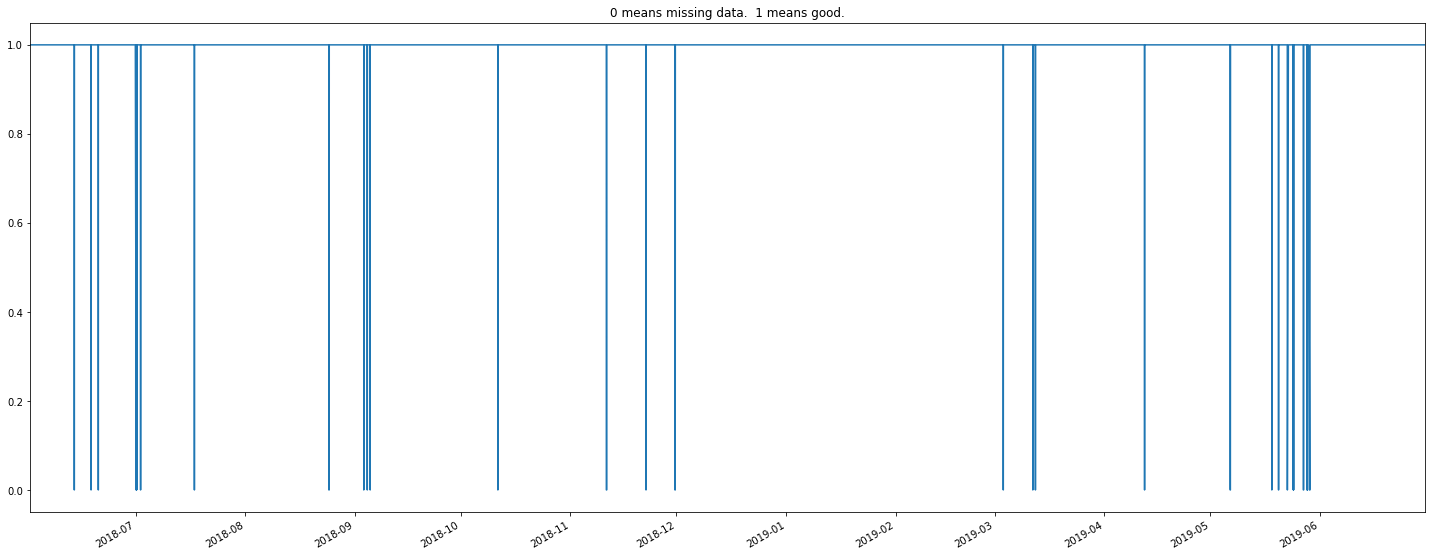

In [28]:
ax = series.clip(upper=1).plot(figsize=(25, 10))
ax.set_title('0 means missing data.  1 means good.')  #   > 1 means duplicates.
ax.xaxis.set_major_locator(mdates.MonthLocator())

In [ ]:
MISSING_FROM_EUMETSAT = [
    "2018-06-13 14:30",
    "2018-06-13 14:35",
    "2018-06-18 08:25",
    '2018-06-20 09:20:00',
    '2018-06-20 09:25:00', 
    '2018-06-20 09:30:00',
    '2018-06-20 09:35:00', 
    '2018-06-20 09:40:00',
    '2018-07-01 03:00:00', '2018-07-01 03:05:00',
               '2018-07-01 03:10:00', '2018-07-01 03:15:00',
               '2018-07-01 03:20:00', '2018-07-01 04:10:00',
               '2018-07-01 04:20:00', '2018-07-01 04:25:00',
               '2018-07-01 04:30:00', '2018-07-01 04:35:00',
               '2018-07-01 04:40:00', '2018-07-01 04:45:00',
               '2018-07-01 05:05:00', '2018-07-01 05:10:00',
               '2018-07-01 05:15:00',
    '2019-05-29 03:00:00', '2019-05-29 03:05:00',
               '2019-05-29 03:10:00', '2019-05-29 03:15:00',
               '2019-05-29 03:20:00', '2019-05-29 03:25:00',
               '2019-05-29 03:30:00', '2019-05-29 03:35:00',
               '2019-05-29 03:40:00', '2019-05-29 03:45:00',
               '2019-05-29 03:50:00', '2019-05-29 03:55:00',
               '2019-05-29 04:00:00', '2019-05-29 04:05:00',
               '2019-05-29 04:10:00', '2019-05-29 04:15:00',
               '2019-05-29 04:20:00', '2019-05-29 04:25:00',
               '2019-05-29 04:30:00', '2019-05-29 04:35:00',
               '2019-05-29 04:40:00', '2019-05-29 04:45:00',
               '2019-05-29 04:50:00', '2019-05-29 04:55:00',
               '2019-05-29 05:00:00', '2019-05-29 05:05:00',
               '2019-05-29 05:10:00', '2019-05-29 05:15:00',
               '2019-05-29 05:20:00', '2019-05-29 05:25:00',
               '2019-05-29 05:30:00', '2019-05-29 05:35:00',
               '2019-05-29 05:40:00', '2019-05-29 05:45:00',
               '2019-05-29 05:50:00', '2019-05-29 05:55:00',
               '2019-05-29 06:00:00', '2019-05-29 06:05:00'
]